# I. Lý thuyết

1) Tại sao mô hình R-CNN lại có tốc độ xử lý chậm?

B. Do các vùng region proposal được dự báo bounding box và phân loại nhãn một cách độc lập.

2) Chỉ số mAP trong các thuật toán object detection được tính toán theo cách nào ?

D. Tính toán chỉ số AP trên từng category: Sắp xếp các Prediction Boxes của một category theo điểm số xác suất giảm dần. Thực hiện matching các Prediction Box với Ground Truth Box sao cho nếu IoU > 0.5 thì được xem là positive và trái lại là negative. Nếu Positive thì Precision sẽ có tử và mẫu cùng tăng lên 1 trong khi Recall có tử số tăng lên 1. Nếu Negative thì Precision có tử giữ nguyên và mẫu tăng lên 1 trong khi Recall không thay đổi. Tính AP = diện tích dưới đường cong Precion Recall. mAP bằng trung bình AP của toàn bộ các category.

3) Phương pháp Non Max Suppression sẽ làm gì để giảm thiểu số lượng các bounding box ?

D. Dựa vào mức độ overlapping để giữ lại một bounding box có điểm số cao hơn nếu chúng chồng lấn nhau lớn.

4) Trong mô hình Fast R-CNN chúng ta thêm một nhánh mạng RPN có tác dụng gì?
 
C. Dự báo bounding box và nhãn cho các vùng Region of Interest có khả năng cao chứa vật thể.

5) Anchor Box là gì?

B. Là những hình chữ nhật với kích thước xác định trước gắn liền với một pixel để làm cơ sở điều chỉnh phần bù (offset) của các tọa độ nhằm dự báo bounding box.


# II. Thực hành 

Các câu bên dưới qui ước chung bounding box đều có tọa độ là (x, y, w, h) lần lượt tương ứng với (x, y) là điểm top-left và (w, h) là kích thước chiều rộng và cao.

6) Xây dựng hàm tính toán IoU giữa hai bounding box.

7) Giả sử các bounding box dự báo cho một category có tọa độ lần lượt là:

[10, 10, 50, 20], [15, 15, 55, 25], [50, 20, 20, 25], [20, 50, 20, 50], [30, 20, 10, 10]

Các bounding box ground truth lần lượt là:

[10, 10, 45, 25], [45, 20, 20, 25], [30, 25, 10, 10]

Hãy thực hiện vẽ đường cong Precision Recall curve và xây dựng thuật toán tính giá trị AP.

8) Thực hiện visualize các anchor box có tỷ lệ aspect ratio (tỷ lệ width/height) lần lượt là 1, 2, 1/2 trên một feature map kích thước 20 x 20

9) Từ bộ dữ liệu [Vinbigdata-chest-xray](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/data) bao gồm các tọa độ bounding box của 14 nhãn của các loại bệnh khác nhau được chuẩn đoán trên ảnh chụp chest X-ray. Thực hiện biến đổi file dữ liệu train.csv sang định dạng COCO json format. Chi tiết mô tả về dữ liệu bạn đọc ở tab data link trên.

10) Hãy xây dựng thuật toán object detection để  hỗ trợ bác sĩ chuẩn đoán bệnh. Để không phải download dữ liệu, bạn nên run một notebook trên kaggle và trích dẫn link sang bài làm của bạn.

##### 6) Xây dựng hàm tính toán IoU giữa hai bounding box.

In [ ]:
def IOU(b1, b2):
  union_box, intersect_box = [0,0], [0,0]
  #caculate width union_box, intersect_box
  if b1[0] < b2[0]:
    if (b1[0] + b1[2]) < (b2[0] + b2[2]):
      union_box[0] = b2[0] + b2[2] - b1[0]
      intersect_box[0] = b1[0] + b1[2] - b2[0]
    else:
      union_box[0] = b1[2]
      intersect_box[0] = b2[2]
  else:
    if(b2[0] + b2[2]) < (b1[0] + b1[2]):
      union_box[0] = b1[0] + b1[2] - b2[0]
      intersect_box[0] = b2[0] + b2[2] - b1[0]
    else:
      union_box[0] = b2[2]
      intersect_box[0] = b1[2]
  #caculate height union_box, intersect_box
  if b1[1] > b2[1]:
    if (b1[1] - b1[3]) < (b2[1] - b2[3]):
      union_box[1] = b1[3]
      intersect_box[1] = b2[3]
    else:
      union_box[1] = b1[1] - (b2[1] - b2[3])
      intersect_box[1] = b2[1] - (b1[1] - b1[3])
  else:
    if (b2[1] - b2[3]) < (b1[1] - b1[3]):
      union_box[1] = b2[3]
      intersect_box[1] = b1[3]
    else:
      union_box[1] = b2[1] - (b1[1] - b1[3])
      intersect_box[1] = b1[1] - (b2[1] - b2[3])

  #caculate IOU
  iou = (intersect_box[0] * intersect_box[1])/(union_box[0] * union_box[1])
  return iou



In [ ]:
IOU((-4,1,3,2), (-3,0,1,2))

0.1111111111111111

##### 7) Giả sử các bounding box dự báo cho một category có tọa độ lần lượt là:

[10, 10, 50, 20], [15, 15, 55, 25], [50, 20, 20, 25], [20, 50, 20, 50], [30, 20, 10, 10]

Các bounding box ground truth lần lượt là:

[10, 10, 45, 25], [45, 20, 20, 25], [30, 25, 10, 10]

Hãy thực hiện vẽ đường cong Precision Recall curve và xây dựng thuật toán tính giá trị AP.

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
bounding_boxs = [[10, 10, 50, 20], [15, 15, 55, 25], [50, 20, 20, 25], [20, 50, 20, 50], [30, 20, 10, 10]]
ground_truth_boxs = [[10, 10, 45, 25], [45, 20, 20, 25], [30, 25, 10, 10]]
threshold = 0.5
precision = len(bounding_boxs) * [0]
recall = len(bounding_boxs) * [0]
count_precision = 0
count_recall = 0
for i in range(1,len(bounding_boxs)+1):
  count = 0
  for j in range(len(ground_truth_boxs)):
    if(IOU(bounding_boxs[i-1], ground_truth_boxs[j]) > threshold):
      count = 1
      count_precision += 1
      count_recall += 1
      precision[i-1] = count_precision/i
      recall[i-1] = count_recall/len(ground_truth_boxs)
      break
  if count == 0:
    precision[i-1] = count_precision/i
    recall[i-1] = count_recall/len(ground_truth_boxs)


Text(0, 0.5, 'Precision')

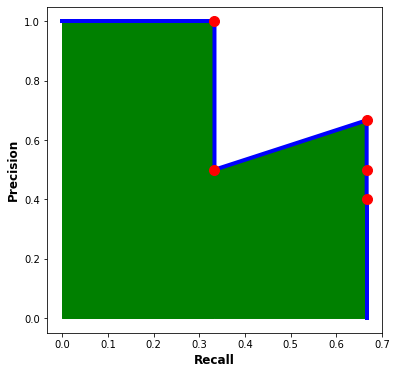

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, linewidth=4, color='blue')
plt.plot([0, recall[0]], [precision[0], precision[0]], linewidth=4, color="blue")
plt.plot([recall[4], recall[4]], [precision[4], 0] , linewidth=4, color="blue")
for i in range(5):
    plt.plot([recall[i]], [precision[i]], marker='o', markersize=10, color="red")

plt.fill_between(recall, precision, color='green')
plt.fill_between([0, recall[0]], [precision[0], precision[0]], color='green')

plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')

In [ ]:
import pandas as pd
df = pd.DataFrame({'Precision': precision,
                   'Recall': recall})
df

,Precision,Recall
0,1.000000,0.333333
1,0.500000,0.333333
2,0.666667,0.666667
3,0.500000,0.666667
4,0.400000,0.666667


In [ ]:
prec_at_rec = []
import numpy as np
for recall_level in np.linspace(0.0, 1.0, 3):
    try:
        print(recall_level)      
        x = df[df['Recall'] >= recall_level]['Precision']
        prec = max(x)
    except:
        prec = 0.0
    prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec) 
print('mAP is ', avg_prec)

0.0
0.5
1.0
mAP is  0.5555555555555555


##### 8) Thực hiện visualize các anchor box có tỷ lệ aspect ratio (tỷ lệ width/height) lần lượt là 1, 2, 1/2 trên một feature map kích thước 20 x 20

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Deep_Learning_Hand_On/Day 7"
# OS.chdir(path)
%cd {path}

Mounted at /content/drive
/content/drive/My Drive/Deep_Learning_Hand_On/Day 7


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import matplotlib.patches as patches

In [ ]:
base_model = VGG16(weights='imagenet')
activation_model = Model(inputs=base_model.inputs, outputs=base_model.layers[1].output)

553476096/553467096 [==============================] - 6s 0us/step


In [ ]:
img_path = './dog.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

activation = activation_model(img_tensor)

###### ratio = 1

<Figure size 288x288 with 0 Axes>

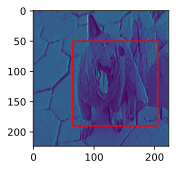

In [ ]:
plt.figure(figsize=(4,4))
fig, ax = plt.subplots()
ax.imshow(activation[0,:,:,2])

# width/height=1
rect = patches.Rectangle((65, 50), 140, 140, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

###### ratio = 2

<Figure size 288x288 with 0 Axes>

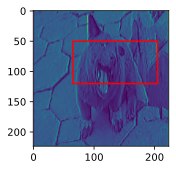

In [ ]:
plt.figure(figsize=(4,4))
fig, ax = plt.subplots()
ax.imshow(activation[0,:,:,2])

# width/height=1
rect = patches.Rectangle((65, 50), 140, 70, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

###### ratio = 0.5

<Figure size 288x288 with 0 Axes>

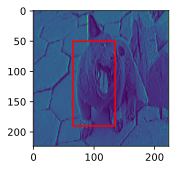

In [ ]:
plt.figure(figsize=(4,4))
fig, ax = plt.subplots()
ax.imshow(activation[0,:,:,2])

# width/height=0.5
rect = patches.Rectangle((65, 50), 70, 140, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

##### 9. Từ bộ dữ liệu Vinbigdata-chest-xray bao gồm các tọa độ bounding box của 14 nhãn của các loại bệnh khác nhau được chuẩn đoán trên ảnh chụp chest X-ray. Thực hiện biến đổi file dữ liệu train.csv sang định dạng COCO json format. Chi tiết mô tả về dữ liệu bạn đọc ở tab data link trên.

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv("train.csv")
train

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [ ]:
len(train)

67914

In [ ]:
class_name_count = train["class_name"].value_counts()
class_name_count

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [ ]:
list_class = list(class_name_count.index)

In [ ]:
coco = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": [],
    "segment_info": []
}

In [ ]:
coco["info"] = {
    "description": "VinBigData Chest X-ray Abnormalities Detection",
    "url": "https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/data",
    "version": "1.0",
    "year": 2020,
    "contributor": "VinAI",
    "date_created": "2020/12/31"
}

for i in range(len(list_class)):
  coco["categories"].append({"supercategory": list_class[i],"id": i,"name": list_class[i]})

for i in range(len(train)):
  coco["licenses"].append({
       "url": "https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/overview",
       "id": i,
       "name": "VinBigData License"
  })
  coco["images"].append({"id": train["image_id"][i], "rad_id": train["rad_id"][i]})
  for j in range(len(list_class)):
    if train["class_name"][i] == list_class[j]:
      coco["annotations"].append({"category_id": j, "bbox": [train["x_min"][i], train["y_min"][i], train["x_max"][i], train["y_max"][i]]})
      break

In [ ]:
coco

{'annotations': [{'bbox': [nan, nan, nan, nan], 'category_id': 0},
  {'bbox': [nan, nan, nan, nan], 'category_id': 0},
  {'bbox': [691.0, 1375.0, 1653.0, 1831.0], 'category_id': 2},
  {'bbox': [1264.0, 743.0, 1611.0, 1019.0], 'category_id': 1},
  {'bbox': [nan, nan, nan, nan], 'category_id': 0},
  {'bbox': [627.0, 357.0, 947.0, 433.0], 'category_id': 3},
  {'bbox': [1347.0, 245.0, 2188.0, 2169.0], 'category_id': 10},
  {'bbox': [557.0, 2352.0, 675.0, 2484.0], 'category_id': 5},
  {'bbox': [1329.0, 743.0, 1521.0, 958.0], 'category_id': 1},
  {'bbox': [1857.0, 1607.0, 2126.0, 2036.0], 'category_id': 4},
  {'bbox': [600.0, 1332.0, 903.0, 1523.0], 'category_id': 6},
  {'bbox': [393.0, 283.0, 822.0, 643.0], 'category_id': 4},
  {'bbox': [nan, nan, nan, nan], 'category_id': 0},
  {'bbox': [nan, nan, nan, nan], 'category_id': 0},
  {'bbox': [1292.0, 554.0, 1477.0, 805.0], 'category_id': 1},
  {'bbox': [nan, nan, nan, nan], 'category_id': 0},
  {'bbox': [nan, nan, nan, nan], 'category_id': 0},

##### 10. Hãy xây dựng thuật toán object detection để hỗ trợ bác sĩ chuẩn đoán bệnh. Để không phải download dữ liệu, bạn nên run một notebook trên kaggle và trích dẫn link sang bài làm của bạn.

link_reference: 